### Buscar questões do dataset Chave

In [2]:
import manager_dataset as MD
import question_processing as QP


questions = MD.questions(treated=True)
incosiderate_classes = ['X', 'MANNER', 'OBJECT', 'OTHER']  # DEFINITION
questions = QP.remove_incosiderate_classes(questions, incosiderate_classes)  # Question with incosiderate class is removed
print(len(questions))

2973


### X y

In [3]:
import random
import numpy as np


random.seed = 3
random.shuffle(questions)

X, y = QP.separete_questions(questions)
X = np.array(X)
y = np.array(y)

### Modelo Word2Vec

In [4]:
%%time
from gensim.models import KeyedVectors


w2v_patch = 'data/word_embedding/cbow_s300.txt'
#w2v_patch = 'data/word_embedding/cbow_s50.txt'  # Fast test
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

C:\Users\55519\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\55519\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


Wall time: 3min 20s


### Modelos de representação em vetor

In [1]:
import numpy as np
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


def count_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return CountVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)


def tfidf_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        ret = np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
        return ret

class HybridVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.bow = count_vectorizer()
        
    
    def fit(self, X, y):
        self.bow.fit(X)
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            bow = self.bow.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, bow[0]]))
        ret = np.array(ret)
        return ret

class TfidfHybridVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.tf = tfidf_vectorizer()
        
    
    def fit(self, X, y):
        self.tf.fit(X)
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            tf = self.tf.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, tf[0]]))
        ret = np.array(ret)
        return ret

class SequenceHybridVectorizer(object):
    def __init__(self, word2vec, tfidf=False):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.word2weight = None
        self.tfidf = tfidf
        self.bow = count_vectorizer()
        
    
    def fit(self, X, y):
        self.bow.fit(X)
        tfidf = tfidf_vectorizer()
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            vector = np.array([])
            maxWords = 32
            count = 0
            for word in sentence:
                if count < maxWords:
                    if word in self.word2vec:
                        count += 1
                        if self.tfidf:
                            vector = np.concatenate([vector, self.word2vec[word] * self.word2weight[word]])
                        else:
                            vector = np.concatenate([vector, self.word2vec[word]])
            for i in range(maxWords-count):
                vector = np.concatenate([vector, np.zeros(self.dim)])
            bow = self.bow.transform([sentence]).toarray()
            vector = np.concatenate([vector, bow[0]])
            ret.append(vector)
        
        ret = np.array(ret)
        return ret

## Definir classificadores

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier


classifiers = {}  # {'classifier': (VectorizeModel, Classifier)}

lbs = ["bag-of-words", 
        "TF-IDF", 
        "Word2Vec",
        "HYBRID_BoW",
        "HYBRID_TF-IDF"]

In [21]:
lbs = ["bag-of-words", 
        "TF-IDF", 
        "Word2Vec"]
classifiers[lbs[0]] = (LinearSVC(), count_vectorizer())
classifiers[lbs[1]] = (LinearSVC(), tfidf_vectorizer())
classifiers[lbs[2]] = (LinearSVC(), MeanEmbeddingVectorizer(model_w2v))

In [7]:
lbs = [ "BOW",
        "TFIDF",
        "W2V",
        "HYBRID"]

classifiers[lbs[0]] = (LinearSVC(), count_vectorizer())
classifiers[lbs[1]] = (LinearSVC(), tfidf_vectorizer())
classifiers[lbs[2]] = (LinearSVC(), MeanEmbeddingVectorizer(model_w2v))
classifiers[lbs[3]] = (LinearSVC(), TfidfHybridVectorizer(model_w2v))

#### SVM Linear

In [13]:
classifiers[lbs[0]] = (LinearSVC(), count_vectorizer())

In [14]:
classifiers[lbs[1]] = (LinearSVC(), tfidf_vectorizer())

In [15]:
classifiers[lbs[2]] = (LinearSVC(), MeanEmbeddingVectorizer(model_w2v))

In [16]:
classifiers[lbs[3]] = (LinearSVC(), HybridVectorizer(model_w2v))

In [17]:
classifiers[lbs[4]] = (LinearSVC(), TfidfHybridVectorizer(model_w2v))

In [ ]:
classifiers["Hybrid sequence"] = (LinearSVC(), SequenceHybridVectorizer(model_w2v))

In [ ]:
classifiers["Linear"] = (LinearSVC(), count_vectorizer())

In [ ]:
classifiers["Polynomial"] = (SVC(kernel="poly", degree=3, gamma=0.4), count_vectorizer())

In [ ]:
classifiers["RBF"] = (SVC(kernel="rbf", gamma=0.1), count_vectorizer())

In [ ]:
classifiers["Sigmoid"] = (SVC(kernel="sigmoid"), count_vectorizer())

#### Naive Bayes

In [ ]:
classifiers["NB mult"] = (MultinomialNB(), count_vectorizer())

In [ ]:
classifiers["NB mult tfidf"] = (MultinomialNB(), tfidf_vectorizer())

In [ ]:
classifiers["NB bernoulli"] = (BernoulliNB(), count_vectorizer())

In [ ]:
classifiers["NB bern tfidf"] = (BernoulliNB(), tfidf_vectorizer())

#### ExtraTrees

In [ ]:
classifiers["ETree"] = (ExtraTreesClassifier(n_estimators=200), count_vectorizer())

In [ ]:
classifiers["ETree tfidf"] = (ExtraTreesClassifier(n_estimators=200), tfidf_vectorizer())

In [ ]:
classifiers["ETree W2V"] = (ExtraTreesClassifier(n_estimators=200), MeanEmbeddingVectorizer(w2v_300))

## Testes

In [8]:
%%time
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

n = 40
k = 5
size_train = 0
table = []

while (size_train +n) <= (len(X)-200):
    size_train += n
    size_test = len(X) - size_train
    print ('\nTrain:', size_train, 'Test:', size_test, end=': ')
    
    rs = ShuffleSplit(n_splits=k, train_size=size_train, test_size=size_test, random_state=0)
    
    for classifier_name in classifiers:
        print(' ', classifier_name, end=' ')
        accuracy = []
        precision = []
        recall = []
        f1 = []
        confusion = []
        for train_indexs, test_indexs in rs.split(X):
            print('.', end='')
            x_train = X[train_indexs]
            y_train = y[train_indexs]
            x_test = X[test_indexs]
            y_test = y[test_indexs]
            
            pipe = Pipeline([("vector_model", classifiers[classifier_name][1]), ("classifer", classifiers[classifier_name][0])])
            model = pipe.fit(x_train, y_train)
            result = model.predict(x_test)
            score = {}
            accuracy.append(accuracy_score(result, y_test))
            precision.append(precision_score(result, y_test, average="macro"))
            recall.append(recall_score(result, y_test, average="macro"))
            f1.append(f1_score(result, y_test, average="macro"))
            confusion.append(confusion_matrix(result, y_test))
        
        table.append({'Model': classifier_name, 
                      'accuracy': np.mean(accuracy),
                      'precision': np.mean(precision),
                      'recall': np.mean(recall),
                      'f1': np.mean(f1),
                      'confusion': np.mean(confusion, axis=0),
                      'train_size': size_train})
print('')


Train: 40 Test: 2933:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 80 Test: 2893:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 120 Test: 2853:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 160 Test: 2813:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 200 Test: 2773:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 240 Test: 2733:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 280 Test: 2693:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 320 Test: 2653:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 360 Test: 2613:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 400 Test: 2573:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 440 Test: 2533:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 480 Test: 2493:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 520 Test: 2453:   BOW .....  TFIDF .....  W2V .....  HYBRID .....
Train: 560 Test: 2413:   BOW .....  TFIDF .....  W2V

## Imprimir Resultados

[Text(0,0.5,'F1-Score')]

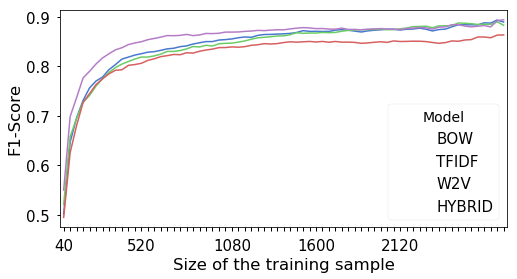

In [10]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

names = lbs
df = pd.DataFrame(table)

aux = df[df.Model.map(lambda x: x in names)]

sorterIndex = dict(zip(lbs,range(len(lbs))))
aux['models_sort'] = aux['Model'].map(sorterIndex)
aux.sort_values(['Model'], \
        ascending = [1], inplace = True)
aux.drop('models_sort', 1, inplace = True)


col_list = ["black", "black", "black", "black", "black"]
col_list_palette = sns.xkcd_palette(col_list)
#sns.set_palette(col_list_palette)
sns.set_palette(sns.color_palette("muted", 5))


#df = df.drop('accuracy', 1).drop('precision', 1).drop('recall', 1).drop('train_size', 1)

plt.figure(figsize=(8, 4))

fig = sns.pointplot(x='train_size', y='f1', hue='Model', 
                    data=df[df.Model.map(lambda x: x in names)],
                    #markers=['o',7,'p','s','x'],
                    markers=['','','','',''],
                    lineheight=1
                   )

for ind, label in enumerate(fig.get_xticklabels()):
    if ind == 0 or ind == 12 or ind == 26 or ind == 39 or ind == 52:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.setp(fig.lines,linewidth=1.5)
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="f1")
fig.set(xlabel="Size of the training sample")
fig.set(ylabel="F1-Score")

In [64]:
def print_scores(model):
    last = {}
    for t in table:
        if t['Model'] == model:
            last['precision'] = t['precision']
            last['recall'] = t['recall']
            last['f1'] = t['f1']
            last['accuracy'] = t['accuracy']
    print ('Recall: ', round(last['recall'],4))
    print ('Precision: ', round(last['precision'],4))
    print ('F1: ', round(last['f1'],4))
    print ('Accuracy: ', round(last['accuracy'],4))

print ('\n\n'+lbs[0]+':\n')
print_scores(lbs[0])
print ('\n\n'+lbs[1]+':\n')
print_scores(lbs[1])
print ('\n\n'+lbs[2]+':\n')
print_scores(lbs[2])
print ('\n\n'+lbs[3]+':\n')
print_scores(lbs[3])
#print ('\n\n'+lbs[4]+':\n')
#print_scores(lbs[4])




BOW:

Recall:  0.8727
Precision:  0.8719
F1:  0.8685
Accuracy:  0.8795


TFIDF:

Recall:  0.8754
Precision:  0.8752
F1:  0.8724
Accuracy:  0.8838


W2V:

Recall:  0.8487
Precision:  0.8472
F1:  0.8462
Accuracy:  0.8603


HYBRID:

Recall:  0.8964
Precision:  0.892
F1:  0.8923
Accuracy:  0.9004


In [56]:
import scipy

a = []
b = []

for t in table:
    if t['Model'] == lbs[1]:
        a.append(t['f1'])
    if t['Model'] == lbs[3]:
        b.append(t['f1'])

scipy.stats.ttest_ind(a, b)

Ttest_indResult(statistic=-2.195862978982542, pvalue=0.030323557512371233)

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(int(cm[i, j]), fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

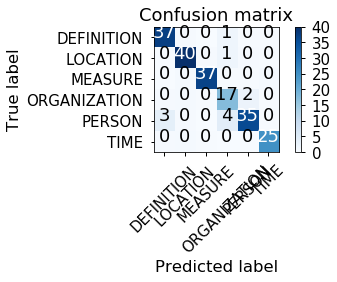

In [20]:
plot_confusion_matrix(table[-1]['confusion'], ['DEFINITION', 'LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'])

In [40]:
table[-1]

{'Model': 'HYBRID',
 'accuracy': 0.9051643192488263,
 'confusion': array([[37.6,  0.4,  0. ,  1.8,  0.2,  0.2],
        [ 0. , 40. ,  0.4,  1.8,  0.4,  0.2],
        [ 0. ,  0.6, 37. ,  0.2,  0.2,  0.6],
        [ 0.4,  0.6,  0.2, 17.4,  2.2,  0.2],
        [ 3.6,  0.4,  0. ,  4.2, 35.8,  0.2],
        [ 0.4,  0.6,  0.2,  0. ,  0. , 25. ]]),
 'f1': 0.8941127652183762,
 'precision': 0.8919979179239099,
 'recall': 0.9034566117159656,
 'train_size': 2760}

In [17]:
svm_ = classifiers['BOW'][0]
svm_.classes_

array(['DEFINITION', 'LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON',
       'TIME'], dtype='<U12')

In [39]:
table[-1]['confusion']

array([[37.6,  0.4,  0. ,  1.8,  0.2,  0.2],
       [ 0. , 40. ,  0.4,  1.8,  0.4,  0.2],
       [ 0. ,  0.6, 37. ,  0.2,  0.2,  0.6],
       [ 0.4,  0.6,  0.2, 17.4,  2.2,  0.2],
       [ 3.6,  0.4,  0. ,  4.2, 35.8,  0.2],
       [ 0.4,  0.6,  0.2,  0. ,  0. , 25. ]])

In [37]:
table[-4]

{'Model': 'BOW',
 'accuracy': 0.9004694835680752,
 'confusion': array([[40.8,  0.8,  0.4,  2.2,  1. ,  0.2],
        [ 0.2, 39.2,  0.4,  1.4,  0.6,  0.4],
        [ 0. ,  0.4, 36. ,  0.4,  0.6,  1. ],
        [ 0.4,  1.2,  0.2, 17. ,  2.2,  0.4],
        [ 0.6,  0.4,  0.6,  4.4, 34.4,  0. ],
        [ 0. ,  0.6,  0.2,  0. ,  0. , 24.4]]),
 'f1': 0.8894929653329327,
 'precision': 0.8851764000693706,
 'recall': 0.8995599255595481,
 'train_size': 2760}

In [80]:
fscores = []
for m in range(4):
    tb = table[-(m+1)]
    classes_ = classifiers[tb['Model']][0].classes_
    
    cm = tb['confusion']
    dic_class = {'Model': tb['Model']}
    #dic_class = {}
    for i_class, _class in enumerate(classes_):
        tp = cm[i_class][i_class]
        fn = sum(cm.transpose()[i_class])-tp
        fp = sum(cm[i_class])-tp
        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        fscore = 2 * ((precision * recall) / (precision + recall))
        dic_class[_class] = fscore
    fscores.append(dic_class)

In [192]:
fscores
for f in fscores:
    print(f['Model'], np.mean([f[k] for k in f.keys() if k != 'Model']))

HYBRID 0.8972362218468066
W2V 0.8666573824445876
TFIDF 0.8853858927597184
BOW 0.8906612774796034


[Text(0,0,'BOW'), Text(0,0,'TFIDF'), Text(0,0,'W2V'), Text(0,0,'HYBRID')]

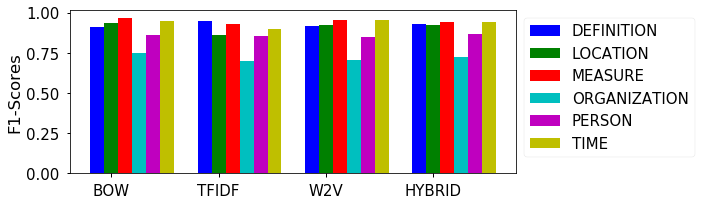

In [197]:
classes_ = ['DEFINITION', 'LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME']
classes__ = {}
for class_ in classes_:
    classes__[class_] = ([x[class_] for x in fscores])

N = 4
ind = np.arange(N)
width = 0.13

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)

rects = []

colors = ['b', 'g', 'r', 'c', 'm', 'y']

for ic, class_ in enumerate(list(classes__.keys())):
    values = classes__[class_]
    
    rect = ax.bar(ind + width*ic, values, width, color=colors[ic])
    control = False
    rects.append(rect)

ax.legend(rects, classes_, bbox_to_anchor=(1, 1))

ax.set_ylabel('F1-Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels(lbs)

In [151]:
list(classes__.keys())

['DEFINITION', 'LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME']

In [87]:

yvals = [4, 9, 2]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [1,2,3]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = [11,12,13]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

### Hybrid Approach

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors
import numpy as np


word2vec = KeyedVectors.load_word2vec_format('cbow_s300.txt')


def tfidf_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, 
                           ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', 
                           lowercase=LOWER)


class HybridVectorizer(object):
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.tfidf = tfidf_vectorizer()
        
    def fit(self, X, y):
        self.tfidf.fit(X)
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] 
                           for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            tfidf = self.tfidf.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, tfidf[0]]))
        ret = np.array(ret)
        return ret